# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

create the two moon dataset

cuda


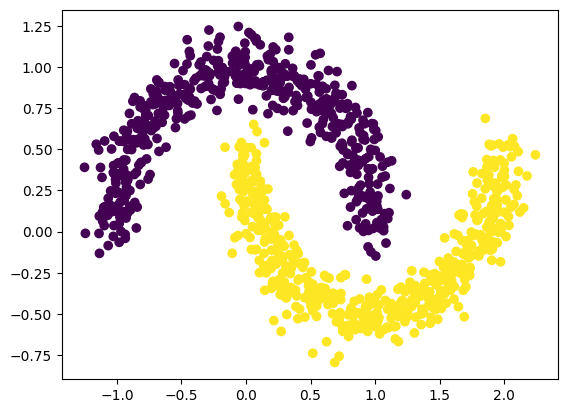

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

Train KAN

In [2]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

num 3
grid.shape torch.Size([2, 4])
grid.shape data tensor([[-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000]])
grid.shape extended torch.Size([2, 10])
grid.shape extended data tensor([[-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000],
        [-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000]])
noises.shape torch.Size([4, 2, 1])
self.coef.shape torch.Size([2, 1, 6])
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.62e-01 | test_loss: 1.63e-01 | reg: 3.93e+00 | : 100%|█| 20/20 [00:05<00:00,  3.60it

saving model version 0.1


(0.9980000257492065, 0.9970000386238098)

Automatic symbolic regression

In [3]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9497208595275879, c=2
fixing (0,1,0) with x, r2=0.9718997478485107, c=1
saving model version 0.2


-0.8477*x_2 + 0.3832*sin(3.1642*x_1 + 7.8194) + 0.7116

How accurate is this formula?

In [4]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9990, device='cuda:0')
test acc of the formula: tensor(0.9940, device='cuda:0')


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

torch.Size([1000, 2])
torch.Size([1000])


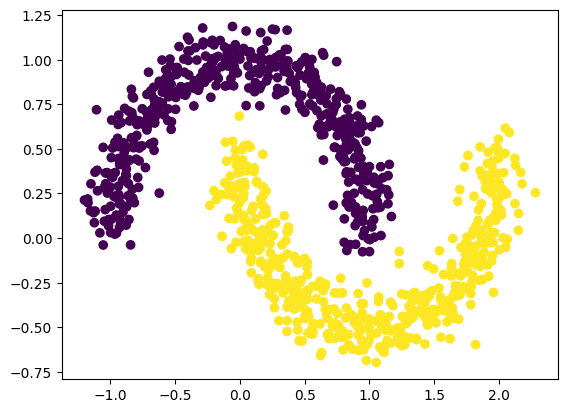

In [5]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

print(dataset['train_input'].shape)
print(dataset['train_label'].shape)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [6]:
dataset['train_label']

tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,

### Train KAN

In [7]:
model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(
    dataset, 
    opt="LBFGS", 
    steps=20, 
    metrics=(train_acc, test_acc), 
    loss_fn=torch.nn.CrossEntropyLoss()
    );

num 3
grid.shape torch.Size([2, 4])
grid.shape data tensor([[-1.0000, -0.3333,  0.3333,  1.0000],
        [-1.0000, -0.3333,  0.3333,  1.0000]])
grid.shape extended torch.Size([2, 10])
grid.shape extended data tensor([[-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000],
        [-3.0000, -2.3333, -1.6667, -1.0000, -0.3333,  0.3333,  1.0000,  1.6667,
          2.3333,  3.0000]])
noises.shape torch.Size([4, 2, 2])
self.coef.shape torch.Size([2, 2, 6])
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 20/20 [00:03<00:00,  6.27it/s]

saving model version 0.1


ValueError: alpha (nan) is outside 0-1 range

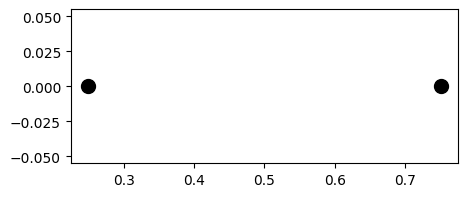

In [8]:
model.plot()

Automatic symbolic regression

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.026039263233542442, c=1
fixing (0,0,1) with x^2, r2=0.9916589856147766, c=2
fixing (0,1,0) with x, r2=0.05051165074110031, c=1
fixing (0,1,1) with sin, r2=0.993134081363678, c=2
saving model version 0.2


In [ ]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

-28051.963*x_1 - 29798.5772*x_2 - 731514.8106

In [ ]:
ex_round(formula2, 4)

171386.5678*(0.2033 - x_1)**2 + 484390.7188*sin(1.3079*x_2 - 8.8746) - 544321.4375

How accurate is this formula?

In [ ]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8190, device='cuda:0')
test acc of the formula: tensor(0.8190, device='cuda:0')
